In [1]:
import torch

from sainomore.data import copying
from sainomore.xai import ElissabethWatcher

In [2]:
config = {
    "n_samples": 500,
    "context_length": 100,
    "n_categories": 5,
    "to_copy": 2,

    "lr": 5e-3,
    "weight_decay": 1e-4,
    "epochs": 1001,

    "batch_size": 64,
    "val_size": 0.2,
}

In [3]:
watcher = ElissabethWatcher.load("version_33", on_cpu=True)

In [4]:
x, y = copying(
    n_samples=1,
    length=watcher.model.config("context_length"),
    n_categories=watcher.model.config("input_vocab_size"),
    to_copy=10,
)

In [5]:
print(x[0, :10], "\n", y[0, -10:], "\n", watcher.model(x).argmax(-1)[0, -10:])

tensor([7, 0, 3, 3, 0, 2, 1, 2, 6, 4]) 
 tensor([7, 0, 3, 3, 0, 2, 1, 2, 6, 4]) 
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [6]:
W_H = watcher.model.get_parameter("layers.0.W_H")
W_H

Parameter containing:
tensor([[0.5148, 0.5563, 0.6730, 0.3072]], requires_grad=True)

(<Figure size 640x480 with 2 Axes>, array([[<Axes: >]], dtype=object))

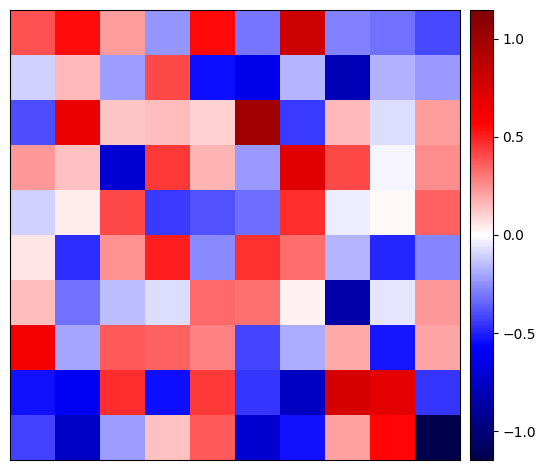

In [7]:
watcher.plot_parameter_matrix("unembedding.weight")

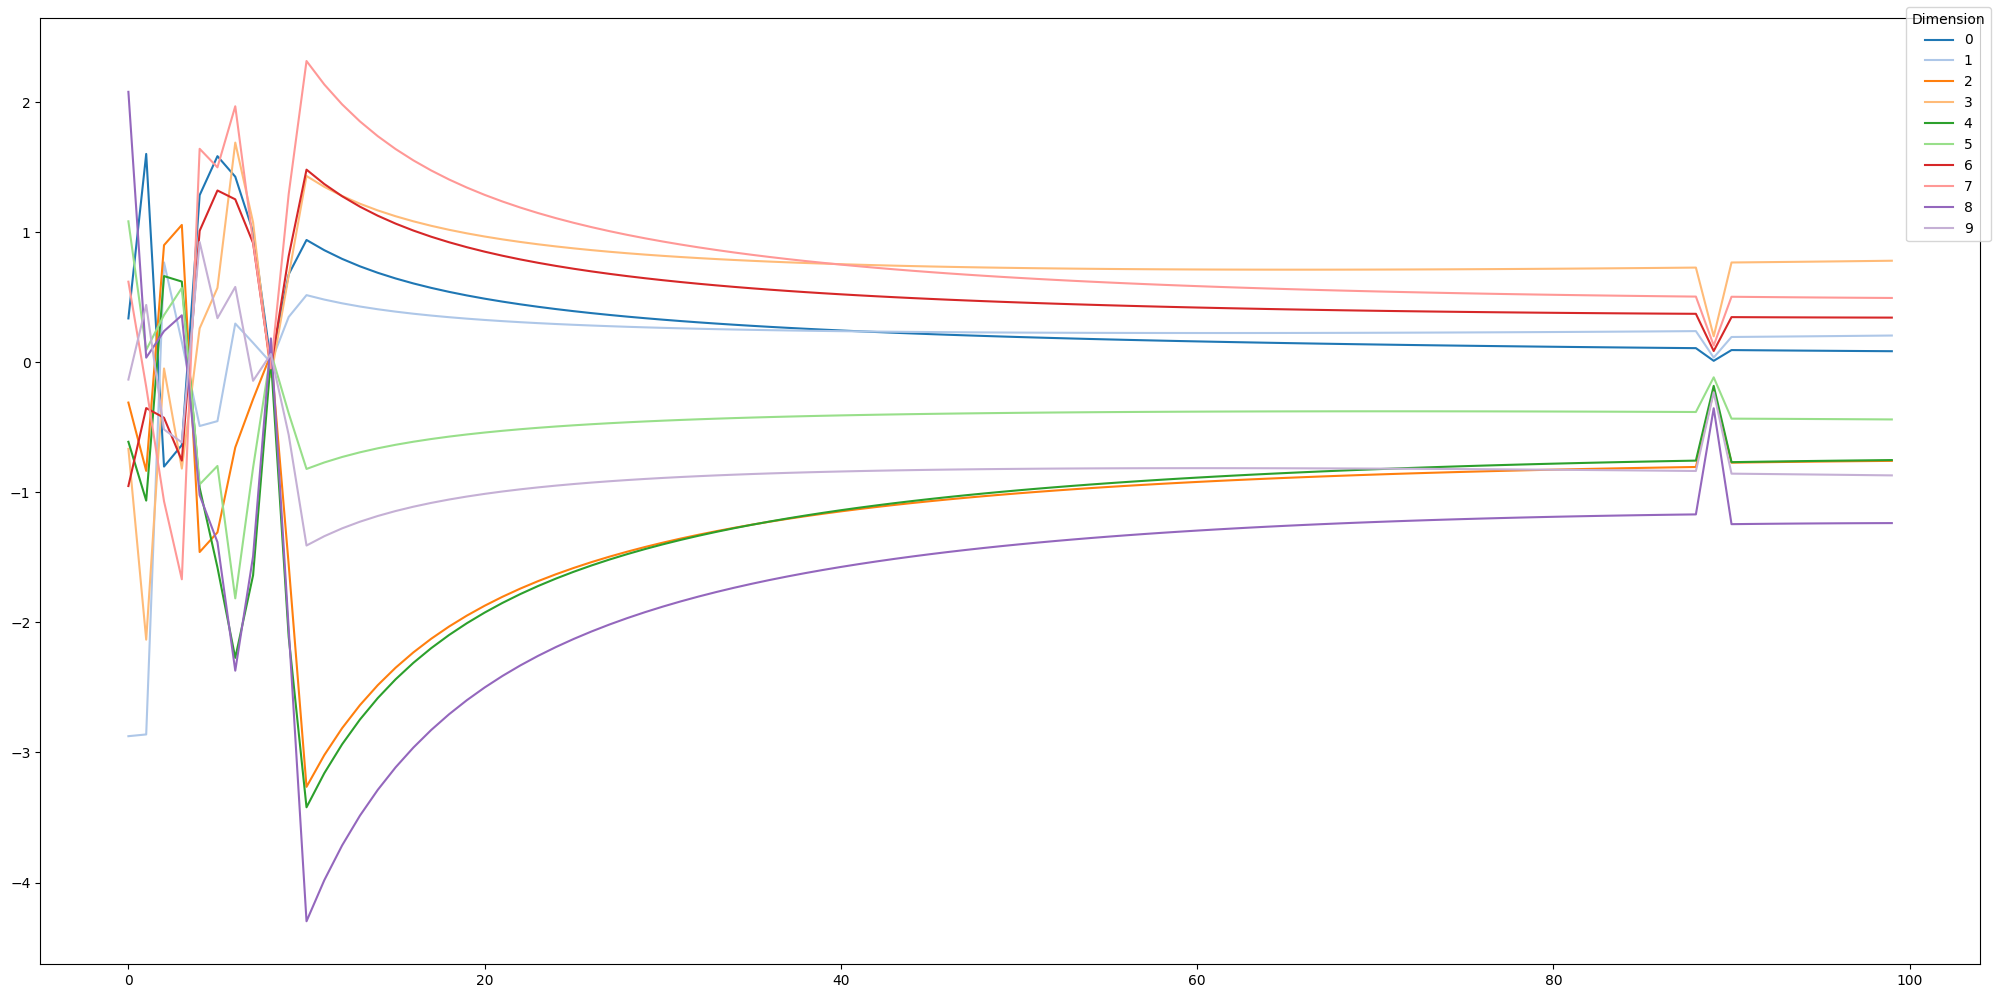

In [9]:
fig, ax = watcher.plot_iss_time(
    x[0],
    append_dims=(1, ),
    project_heads=True,
    project_values=False,
    figsize=(20, 10),
)

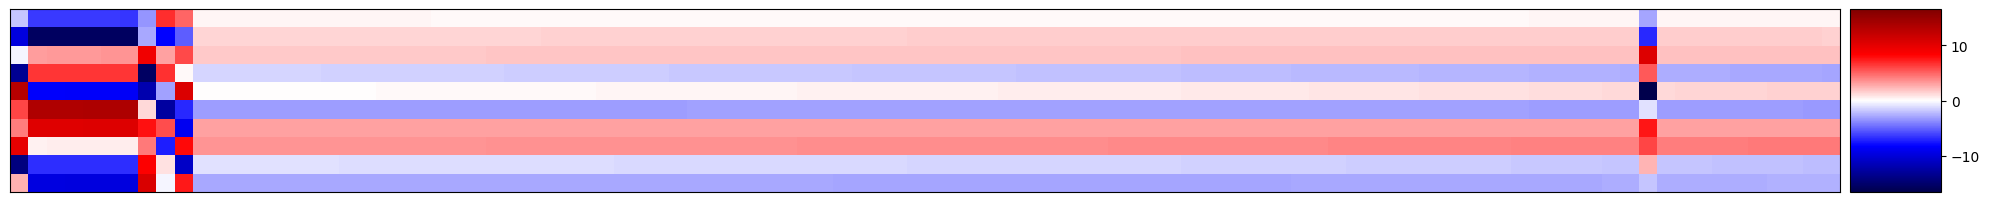

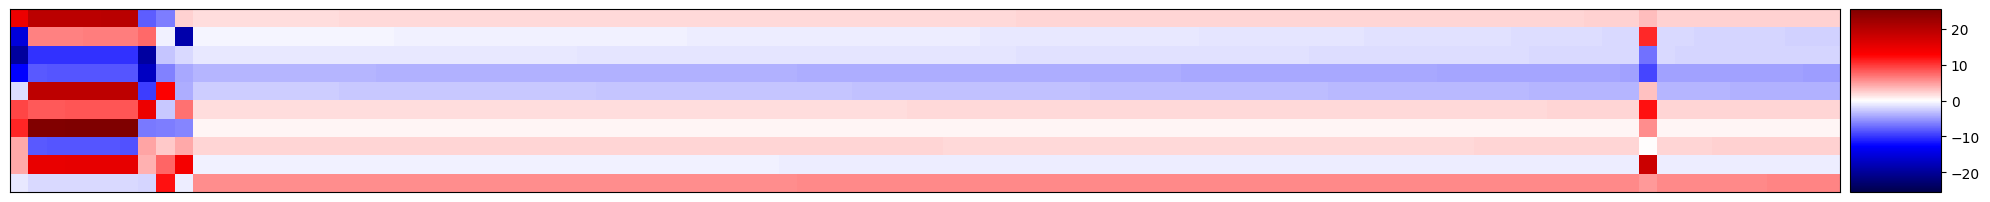

In [13]:
fig, ax = watcher.plot_values(
    x[0],
    log_cmap=False,
    project_heads=True,
    project_values=True,
    figsize=(20, 20),
)
fig, ax = watcher.plot_values(
    x[0],
    log_cmap=False,
    project_heads=True,
    project_values=False,
    figsize=(20, 20),
)

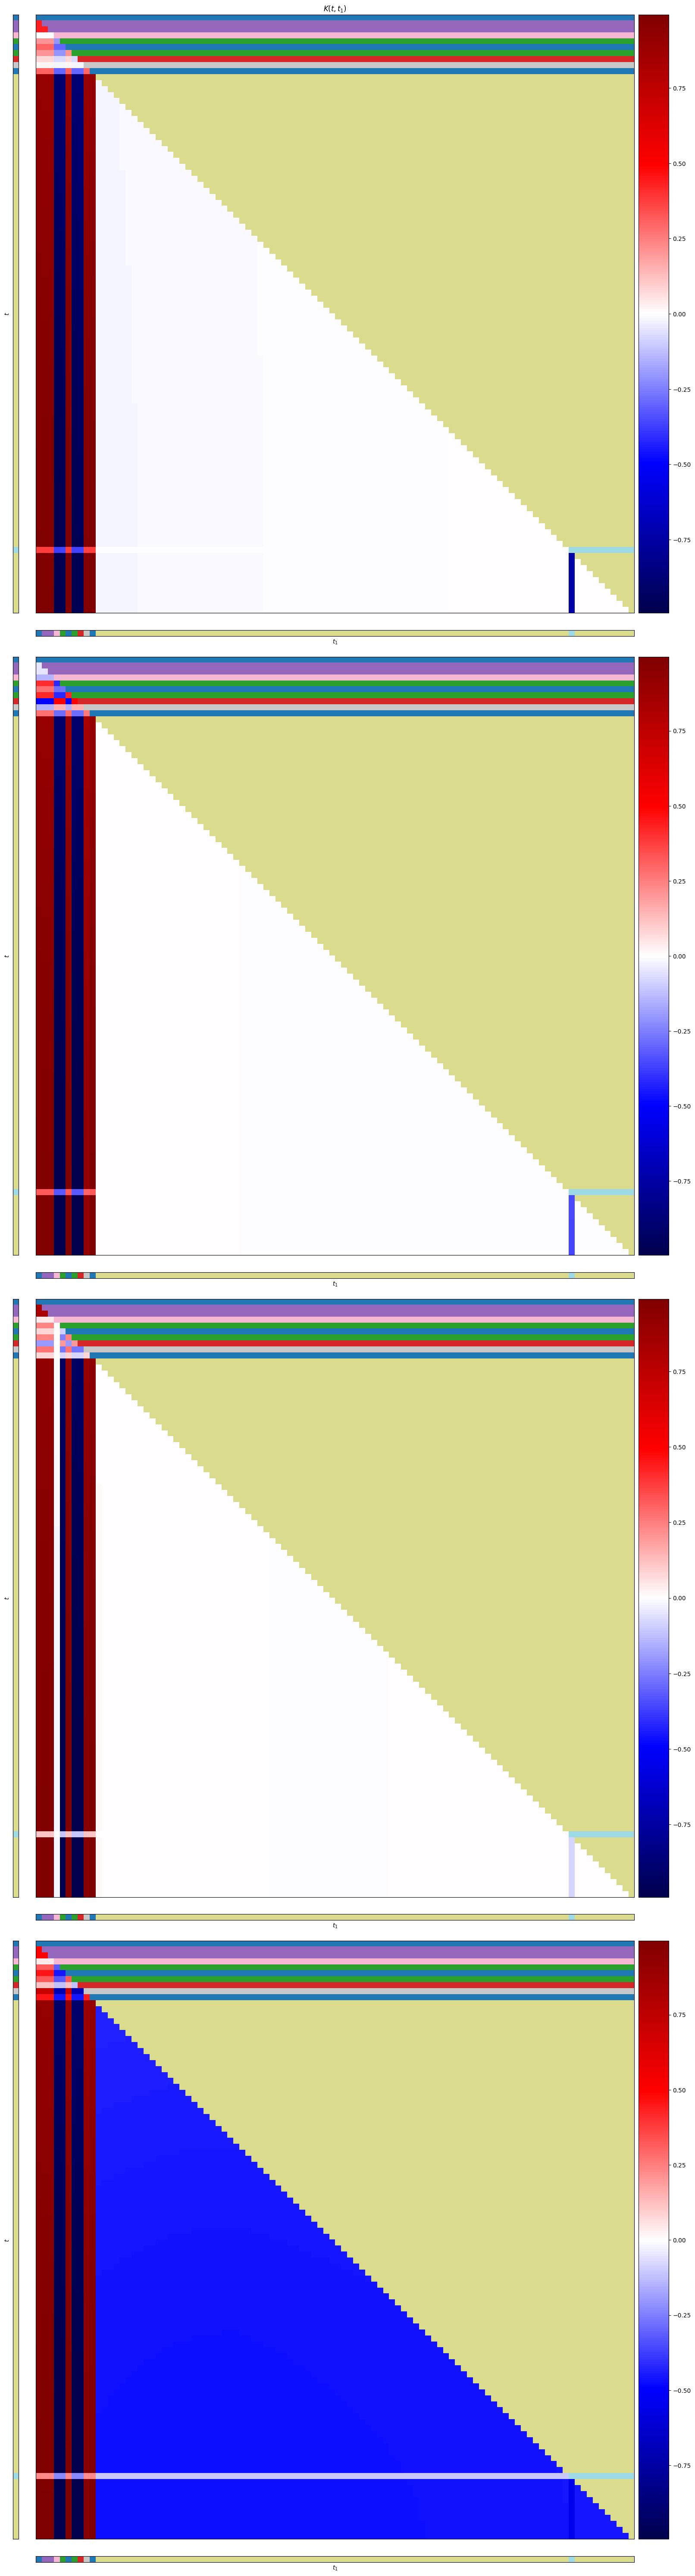

In [13]:
fig, ax = watcher.plot_attention_matrices(
    x[0],
    # total=True,
    cmap="seismic",
    share_cmap=False,
    log_cmap=False,
    causal_mask=True,
    only_kernels=(0, ),
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    center_zero=True,
    cmap_example="tab20",
    figsize=(20, 60),
)
# plt.savefig("plot.pdf")

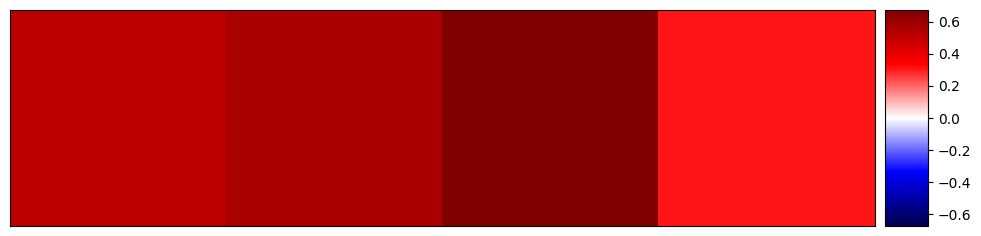

In [14]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_H",
    figsize=(10, 10),
)

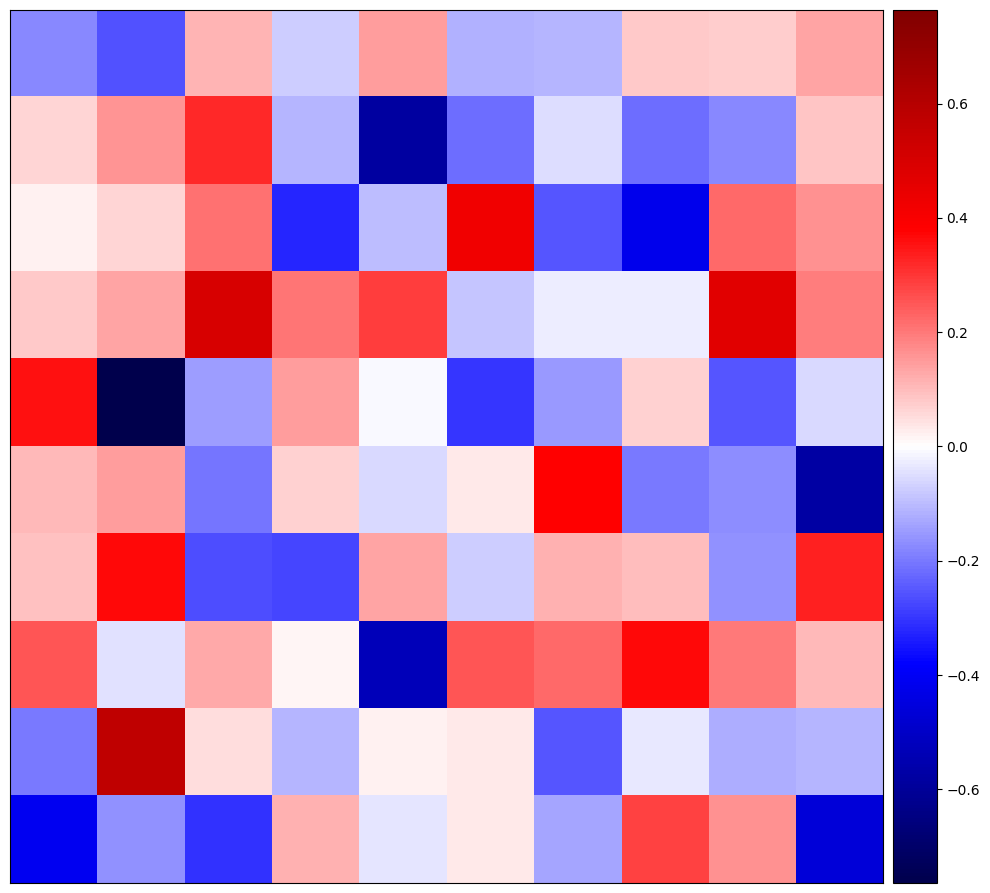

In [15]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_O",
    reduce_dims={2: 0},
    append_dims=(0,1,),
    figsize=(10, 10),
)

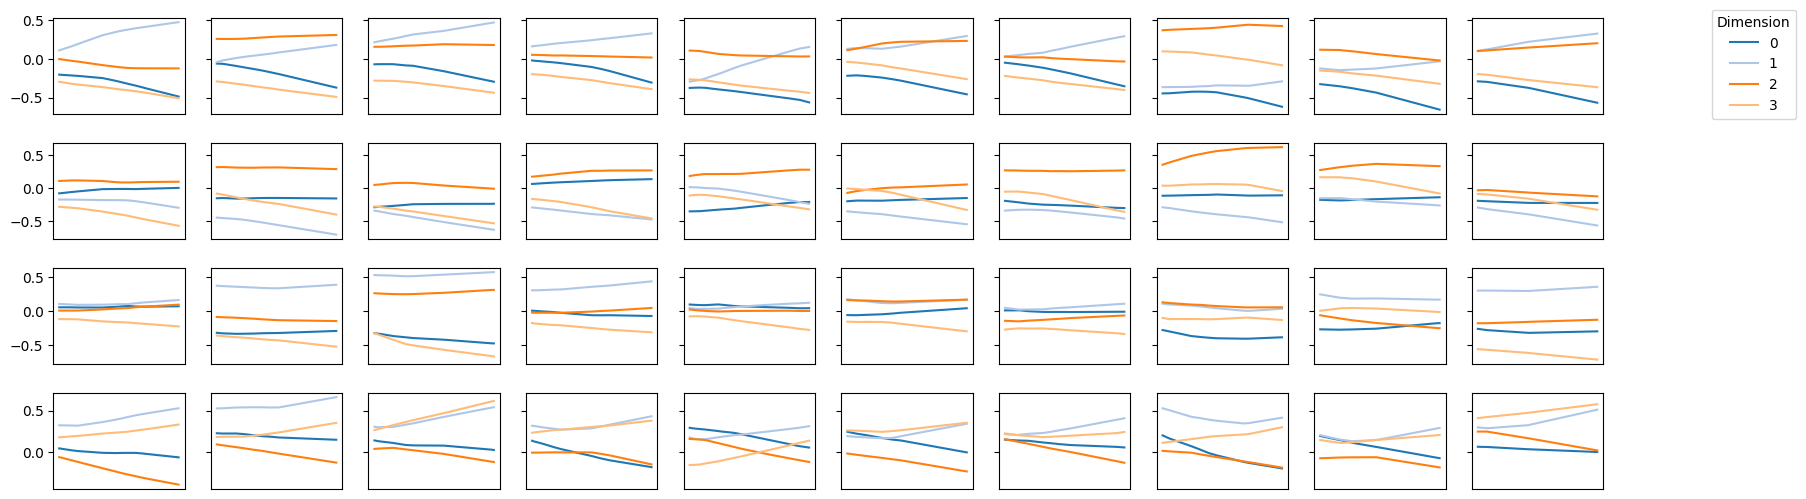

In [16]:
fig, ax = watcher.plot_qkv_probing(
    which="q",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)

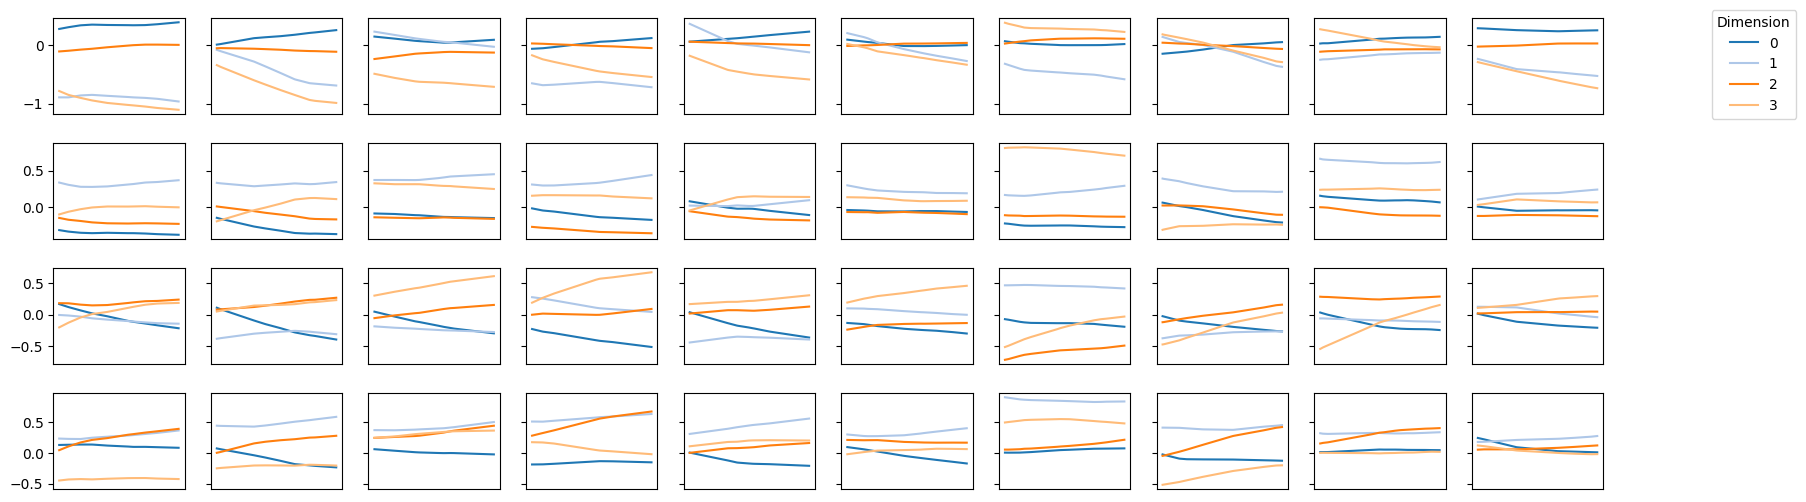

In [17]:
fig, ax = watcher.plot_qkv_probing(
    which="k",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)

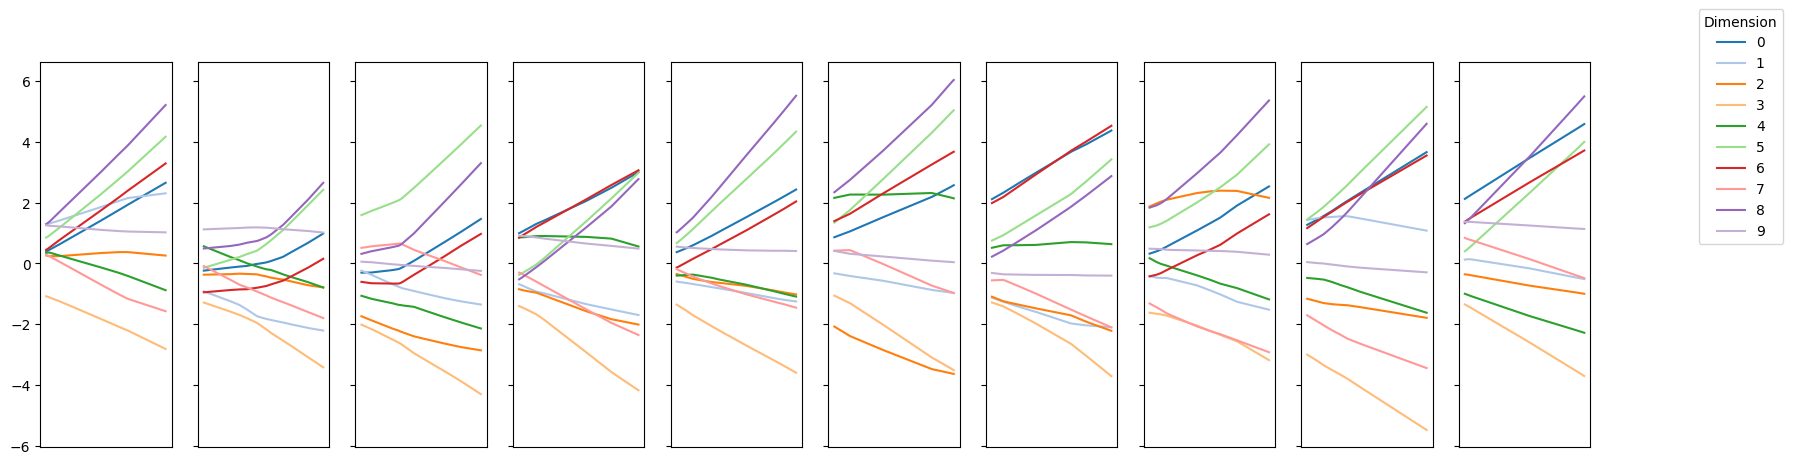

In [18]:
fig, ax = watcher.plot_qkv_probing(
    which="v",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)